In [114]:
# Import required libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Install openpyxl if needed
try:
    import openpyxl
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
    import openpyxl

print("Libraries imported successfully!")


Libraries imported successfully!


In [115]:
# Load all data files
# 1. Load the Catholic schools data
df = pd.read_csv('data/HeatMapCSV.csv')

# 2. Load the ZIP-County crosswalk data
zip_county_df = pd.read_excel('data/ZIP_COUNTY_032025.xlsx')

print("Catholic Schools Data:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print(f"\nZIP-County Crosswalk Data:")
print(f"Shape: {zip_county_df.shape}")
print(f"Columns: {zip_county_df.columns.tolist()}")

print("\nFirst few rows of schools data:")
df.head()


Catholic Schools Data:
Shape: (470, 8)
Columns: ['School', 'Self-Reported Gr. 8 Full Tuition 2024-25 ', 'Total Number of Scholarships 24-25', 'Total K-8 Enrollment 24-25', 'School Address', 'School City', 'State', 'Zip']

ZIP-County Crosswalk Data:
Shape: (54563, 8)
Columns: ['ZIP', 'COUNTY', 'USPS_ZIP_PREF_CITY', 'USPS_ZIP_PREF_STATE', 'RES_RATIO', 'BUS_RATIO', 'OTH_RATIO', 'TOT_RATIO']

First few rows of schools data:


,School,Self-Reported Gr. 8 Full Tuition 2024-25,Total Number of Scholarships 24-25,Total K-8 Enrollment 24-25,School Address,School City,State,Zip
0,All Saints Catholic School,"$6,100.00",18.0,411,19795 Holyoke Ave.,Lakeville,MN,55044-8816
1,Annunciation School,"$6,800.00",17.0,340,525 - 54th St. W.,Minneapolis,MN,55419-1818
2,Ascension School,"$1,400.00",72.0,272,1726 Dupont Ave. N.,Minneapolis,MN,55411-3219
3,"Ave Maria Academy (Maple Grove, MN)","$9,800.00",13.0,161,7000 Jewel Lane N.,Maple Grove,MN,55311-2504
4,Benilde-St. Margaret's Schools,"$15,625.00",8.0,194 (7-8),2501 MN-100,St Louis Park,MN,55416


In [116]:
# Clean and process the data
# Remove empty rows
df_clean = df.dropna(subset=['School', 'Zip']).copy()

# Extract 5-digit ZIP codes from ZIP+4 format (e.g., '55044-8816' -> '55044')
df_clean['zip_code'] = df_clean['Zip'].str[:5]

# Clean the tuition column (remove $ and commas)
df_clean['Tuition_Clean'] = df_clean['Self-Reported Gr. 8 Full Tuition 2024-25 '].str.replace('$', '').str.replace(',', '').astype(float)

# Clean scholarships column
df_clean['Scholarships'] = df_clean['Total Number of Scholarships 24-25']

# Parse enrollment (some have grade ranges in parentheses)
df_clean['Enrollment_Clean'] = df_clean['Total K-8 Enrollment 24-25'].astype(str).str.extract(r'(\d+)').astype(float)

# Process ZIP-County mapping
mn_zip_county = zip_county_df[zip_county_df['USPS_ZIP_PREF_STATE'] == 'MN'].copy()
mn_zip_county_best = mn_zip_county.loc[mn_zip_county.groupby('ZIP')['RES_RATIO'].idxmax()]

# Create mapping ensuring both are strings with leading zeros preserved
zip_to_county_map = dict(zip(mn_zip_county_best['ZIP'].astype(str).str.zfill(5), mn_zip_county_best['COUNTY']))

# Apply county mapping to school data
df_clean['county_fips'] = df_clean['zip_code'].map(zip_to_county_map)


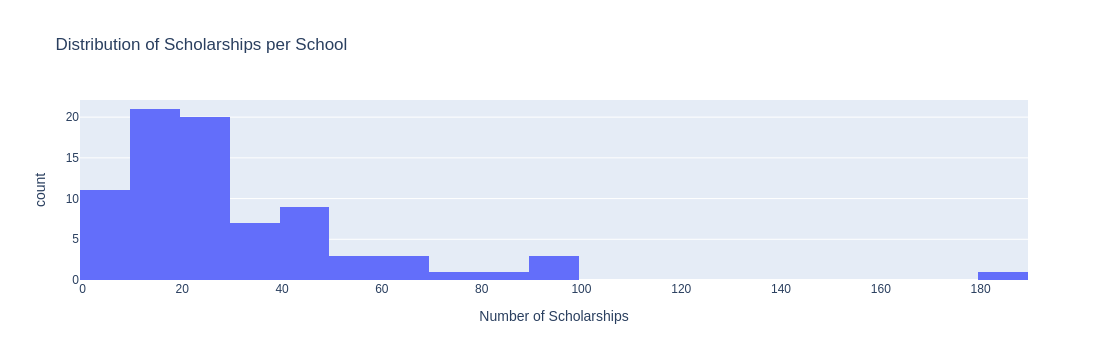

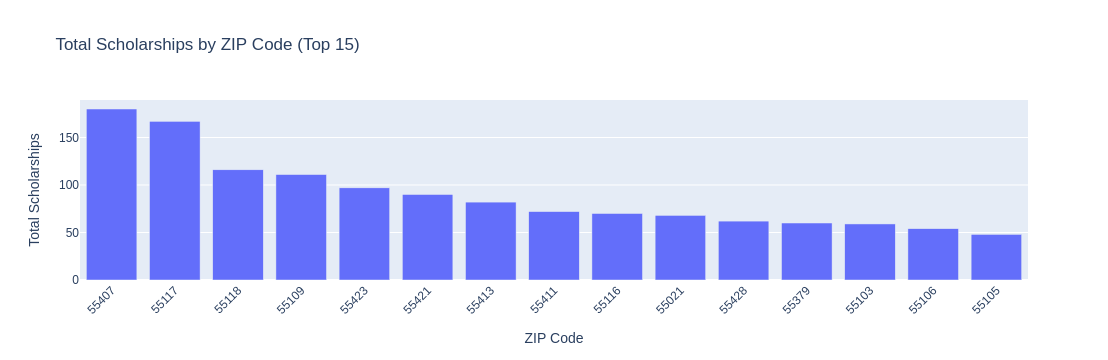

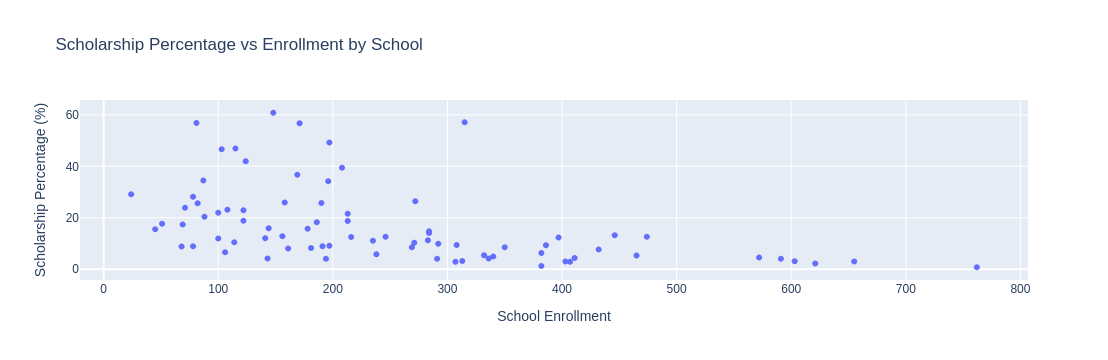

In [117]:
# Create visualizations focused on scholarships

# 1. Scholarship distribution by school
fig1 = px.histogram(
    df_clean,
    x='Scholarships',
    nbins=20,
    title='Distribution of Scholarships per School',
    labels={'Scholarships': 'Number of Scholarships', 'count': 'Number of Schools'}
)
fig1.show()

# 2. Top ZIP codes by total scholarships
zip_aggregated = df_clean.groupby('zip_code').agg({
    'Tuition_Clean': 'mean',
    'Scholarships': 'sum',
    'Enrollment_Clean': 'sum',
    'School': 'count'
}).reset_index()
zip_aggregated.columns = ['zip_code', 'avg_tuition', 'total_scholarships', 'total_enrollment', 'school_count']

fig2 = px.bar(
    zip_aggregated.nlargest(15, 'total_scholarships'),
    x='zip_code',
    y='total_scholarships',
    title='Total Scholarships by ZIP Code (Top 15)',
    labels={'total_scholarships': 'Total Scholarships', 'zip_code': 'ZIP Code'}
)
fig2.update_layout(xaxis_tickangle=-45)
fig2.show()

# 3. Scholarship percentage vs Enrollment scatter plot
# Calculate scholarship percentage (avoid division by zero)
df_clean['scholarship_percentage'] = df_clean.apply(
    lambda row: (row['Scholarships'] / row['Enrollment_Clean'] * 100) if row['Enrollment_Clean'] > 0 else 0, 
    axis=1
)

# Calculate total financial burden: (Tuition - 1000) * Scholarships
df_clean['total_financial_burden'] = (df_clean['Tuition_Clean'] - 1000) * df_clean['Scholarships']

fig3 = px.scatter(
    df_clean,
    x='Enrollment_Clean',
    y='scholarship_percentage',
    hover_name='School',
    hover_data={
        'Scholarships': True,
        'Enrollment_Clean': True,
        'scholarship_percentage': ':.1f',
        'total_financial_burden': ':,.0f'
    },
    title='Scholarship Percentage vs Enrollment by School',
    labels={
        'Enrollment_Clean': 'School Enrollment', 
        'scholarship_percentage': 'Scholarship Percentage (%)',
        'total_financial_burden': 'Total Financial Burden'
    }
)
fig3.show()




In [118]:
# Process mapping results from official ZIP-County data
mapped_schools = df_clean.dropna(subset=['county_fips'])


In [119]:
# Load comprehensive ZIP code coordinates - REQUIRED
# Load the ZIP coordinates file from Excel
zip_coords_df = pd.read_excel('data/mn_zip_cords_excel.xlsx', dtype={'Zip': str})

# Filter for Minnesota and create mapping (adjust column names as needed)
if 'State' in zip_coords_df.columns:
    mn_coords = zip_coords_df[zip_coords_df['State'] == 'MN']
else:
    mn_coords = zip_coords_df  # Assume it's already Minnesota data

# The coordinates are in the "Geo Point" column as "latitude, longitude" strings
zip_col = 'Zip Code'
geo_point_col = 'Geo Point'

# Create the coordinate mapping by parsing the Geo Point column
zip_coord_map = {}
successful_mappings = 0
failed_mappings = 0

for _, row in mn_coords.iterrows():
    zip_code = str(row[zip_col]).zfill(5)  # Ensure 5-digit ZIP code
    geo_point = row[geo_point_col]
    
    if pd.notna(geo_point) and isinstance(geo_point, str):
        try:
            # Split the "latitude, longitude" string
            parts = geo_point.split(',')
            if len(parts) == 2:
                lat_num = float(parts[0].strip())
                lon_num = float(parts[1].strip())
                zip_coord_map[zip_code] = (lat_num, lon_num)
                successful_mappings += 1
            else:
                failed_mappings += 1
        except (ValueError, TypeError):
            failed_mappings += 1
    else:
        failed_mappings += 1

# Apply coordinates to our data
df_clean['lat'] = df_clean['zip_code'].map(lambda x: zip_coord_map.get(x, (None, None))[0] if x in zip_coord_map else None)
df_clean['lon'] = df_clean['zip_code'].map(lambda x: zip_coord_map.get(x, (None, None))[1] if x in zip_coord_map else None)


In [120]:
# Only use schools with valid coordinates for mapping
df_with_coords = df_clean.dropna(subset=['lat', 'lon'])

# Calculate total financial burden: (Tuition - 1000) * Scholarships
df_with_coords = df_with_coords.copy()  # Avoid SettingWithCopyWarning
df_with_coords['total_financial_burden'] = (df_with_coords['Tuition_Clean'] - 1000) * df_with_coords['Scholarships']

# Create scatter map focused on scholarships (only for schools with coordinates)
if len(df_with_coords) > 0:
    fig_scatter = px.scatter_map(
        df_with_coords,
        lat='lat',
        lon='lon',
        color='Scholarships',
        size='scholarship_percentage',
        hover_name='School',
        hover_data={
            'zip_code': True,
            'Scholarships': True,
            'scholarship_percentage': ':.1f',
            'total_financial_burden': ':,.0f',
            'Tuition_Clean': ':.0f',
            'Enrollment_Clean': ':.0f',
            'School City': True
        },
        labels={
            'Tuition_Clean': 'Tuition',
            'Enrollment_Clean': 'Enrollment',
            'scholarship_percentage': 'Scholarship %',
            'total_financial_burden': 'Total Financial Burden'
        },
        color_continuous_scale="Viridis",
        size_max=15,
        map_style="open-street-map",
        title=f"Minnesota Catholic Schools - Scholarships by Location ({len(df_with_coords)} schools with coordinates)",
        zoom=7,
        center={"lat": 45.5, "lon": -93.5}
    )

    fig_scatter.update_layout(height=600)
    fig_scatter.show()


In [121]:
# Prepare data for county-level analysis
mapped_schools = df_clean.dropna(subset=['county_fips'])


In [122]:
# Create county-level aggregated data for choropleth
county_data = mapped_schools.groupby('county_fips').agg({
    'Tuition_Clean': 'mean',
    'Scholarships': 'sum', 
    'Enrollment_Clean': 'sum',
    'School': 'count'
}).reset_index()

county_data.columns = ['county_fips', 'avg_tuition', 'total_scholarships', 'total_enrollment', 'school_count']


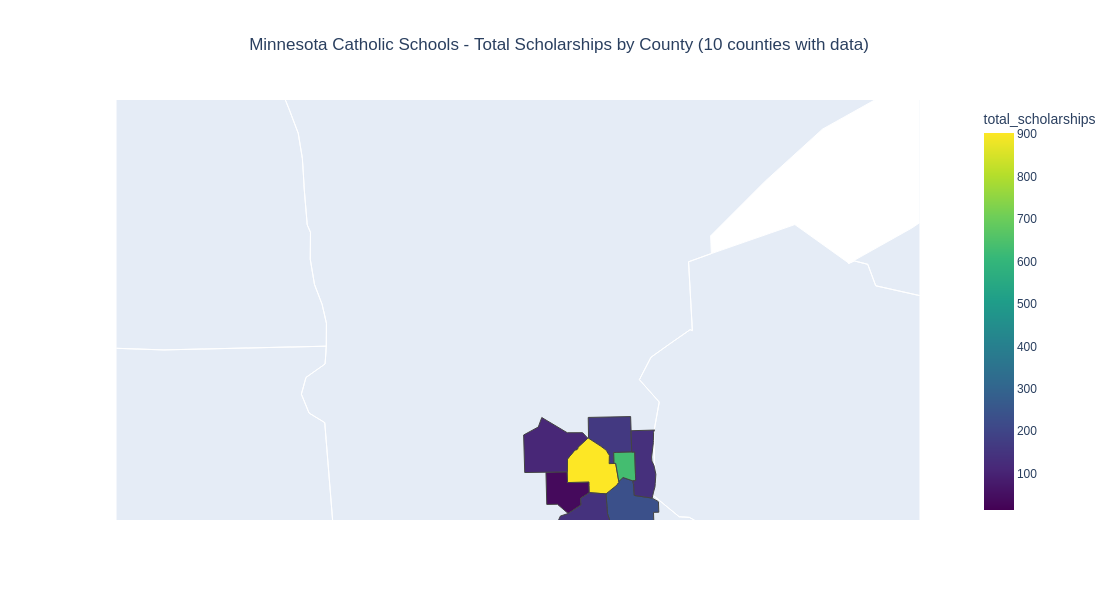

In [123]:
# Create choropleth map focused on scholarships
if len(county_data) > 0:
    fig_choropleth = px.choropleth(
        county_data,
        geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
        locations='county_fips',
        color='total_scholarships',
        hover_name='county_fips',
        hover_data={
            'total_scholarships': True,
            'school_count': True,
            'avg_tuition': ':.0f',
            'total_enrollment': ':.0f'
        },
        color_continuous_scale="Viridis",
        title=f"Minnesota Catholic Schools - Total Scholarships by County ({len(county_data)} counties with data)"
    )

    # Focus on Minnesota
    fig_choropleth.update_geos(
        center=dict(lat=46.3, lon=-94.3),
        projection_scale=8,
        scope='usa'
    )

    fig_choropleth.update_layout(
        title_x=0.5,
        height=600
    )

    fig_choropleth.show()
